## Imports

In [1]:
import xarray as xr
import pathlib
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## specify filepath for data
DATA_FP = pathlib.Path("/Users/theo/research/enso2025_xro/data")

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 100

## Functions

In [2]:
def file_pattern(name, sim, n):
    """
    Function to get file pattern. Args:
        - name: "ts" or "ssh"
        - simulation type: one of "historical" or "ssp585"
        - n: ensemble member ID, ranging from 1 to 50
    """
    return (DATA_FP / "mpi" / name).glob(f"*{sim}*r{n}i*.nc")


def load_member(name, sim, n):
    """load ensemble member. Args:
    - name: "ts" or "ssh"
    - simulation type: one of "historical" or "ssp585"
    - n: ensemble member ID, ranging from 1 to 50
    """
    return xr.open_mfdataset(file_pattern(name, sim, n))


def compute_T_indices(data):
    """
    See Figure 1 in Vialard et al (2025). Compute following indices:
        - T_3: Niño 3 index (5°N–5°S,150°–90°W)
        - T_34: Niño 3.4 index (5°N–5°S,170°–120°W)
    """

    ## specify coords for boxes
    T_3_kwargs = dict(latitude=slice(-5, 5), longitude=slice(210, 270))
    T_34_kwargs = dict(latitude=slice(-5, 5), longitude=slice(190, 240))

    ## compute indices
    T_3 = spatial_avg(data["sst"].sel(T_3_kwargs)).rename("T_3")
    T_34 = spatial_avg(data["sst"].sel(T_34_kwargs)).rename("T_34")

    return xr.merge([T_3, T_34, data["sst_trop"], data["ts_glob"]])


def compute_h_indices(data):
    """
    See Figure 1 in Vialard et al (2025). Compute following indices:
        - h_w: western Pacific SSH (5°N–5°S, 120°E−150°W)
        - h: equatorial Pacific SSH (5°N–5°S, 120°E−75°W)
    """

    ## speicfy coords for boxes
    h_w_kwargs = dict(latitude=slice(-5, 5), longitude=slice(120, 210))
    h_kwargs = dict(latitude=slice(-5, 5), longitude=slice(120, 285))

    ## compute indices
    h_w = spatial_avg(data["ssh"].sel(h_w_kwargs)).rename("h_w")
    h = spatial_avg(data["ssh"].sel(h_kwargs)).rename("h")

    return xr.merge(
        [h_w.rename("h_w"), h.rename("h"), data["ssh_trop"], data["ssh_glob"]]
    )


def compute_member_indices(sim, n):
    """compute T and h indices for given ensemble member and simulation"""

    ## shared arguments
    kwargs = dict(sim=sim, n=n)

    ## compute T indices
    sst = load_member("ts", **kwargs)
    T = compute_T_indices(sst)

    ## compute h indices
    ssh = load_member("ssh", **kwargs)
    h = compute_h_indices(ssh)

    ## return data
    return xr.merge([T, h])


def spatial_avg(data):
    """get spatial average, weighting by cos of latitude"""

    ## get weighted data
    weights = np.cos(np.deg2rad(data.latitude))

    return data.weighted(weights).mean(["latitude", "longitude"])


def load_member_Th(sim, n):
    """Load T and h data for given simulation type and ensemble member"""

    ## shared arguments
    kwargs = dict(sim=sim, n=n)

    ## load data
    sst = load_member("ts", **kwargs)
    ssh = load_member("ssh", **kwargs)

    ## compute indices
    return xr.merge([compute_T_indices(sst), compute_h_indices(ssh)])


def compute_ensemble_Th(save_dir=DATA_FP / "temp"):
    """function to compute and save Th for each ensemble member"""

    for sim in ["historical", "ssp585"]:
        for n in tqdm.tqdm(range(1, 51, 1)):

            ## get save filepath
            save_fp = save_dir / f"Th_{sim}_{n:02d}.nc"

            ## check if file exists
            if save_fp.is_file():
                pass

            else:
                ## compute indices for given member
                Th_ = load_member_Th(sim=sim, n=n).compute()

                ## save to file
                Th_.to_netcdf(save_fp)

    return


def merge_ensemble_Th(load_dir, save_dir, sim):
    """merge files from individual ensemble members into one"""

    ## get filepath for saving
    save_fp = save_dir / f"Th_{sim}.nc"

    ## check if file exists
    if save_fp.is_dir():
        pass

    else:

        ## Load data
        Th = xr.open_mfdataset(
            sorted(list(load_dir.glob(f"*{sim}*.nc"))),
            combine="nested",
            concat_dim="member",
        )

        ## assign values to member dimension
        Th = Th.assign_coords({"member": pd.Index(np.arange(1, 51))})

        ## remove encoding setting which prevents saving
        for name in ["sst_trop", "ts_glob", "ssh_trop", "ssh_glob"]:
            del Th[name].encoding["_FillValue"]

        ## save to file
        Th.to_netcdf(save_fp)

    return Th


def preprocess(Th, save_dir=DATA_FP / "mpi_Th"):
    """preprocess T and h data"""

    ## compute ensemble mean and anomalies
    Th_emean = Th.mean("member")
    Th_anom = Th - Th_emean

    ## define filepaths for saving
    save_fp_emean = pathlib.Path(save_dir, "Th_ensemble_mean.nc")
    save_fp_anom = pathlib.Path(save_dir, "Th.nc")

    ## save to file if not already
    if not save_fp_emean.is_file():
        Th_emean.to_netcdf(save_fp_emean)

    if not save_fp_anom.is_file():
        Th_anom.to_netcdf(save_fp_anom)

    return Th_emean, Th_anom


class eof:
    def __init__(self, data):

        ## stack latitude and longitude into one dimension
        data_stacked = data.stack(posn=["latitude", "longitude"])

        ## find nan values
        nan_mask = np.isnan(data_stacked.isel(time=0))

        ## filter out NaNs and compute SVD
        data_nonan = data_stacked.isel(posn=~nan_mask.values)

        ## compute SVD
        self.u, self.s, self.vt = np.linalg.svd(data_nonan.values, full_matrices=False)

        return

## Compute $T$, $h$ variables

In [3]:
## get directory for saving temporary results
temp_dir = DATA_FP / "temp"

## compute T & h for each ensemble member
compute_ensemble_Th(save_dir=temp_dir)

## merge data into single ensemble
kwargs = dict(load_dir=temp_dir, save_dir=DATA_FP / "mpi_Th")
Th_hist = merge_ensemble_Th(sim="historical", **kwargs)
Th_ssp = merge_ensemble_Th(sim="ssp585", **kwargs)

## merge hist. and ssp simulations
Th = xr.concat([Th_hist, Th_ssp], dim="time")

## preprocess
Th_emean, Th = preprocess(Th)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 18168.17it/s]


### Look at output

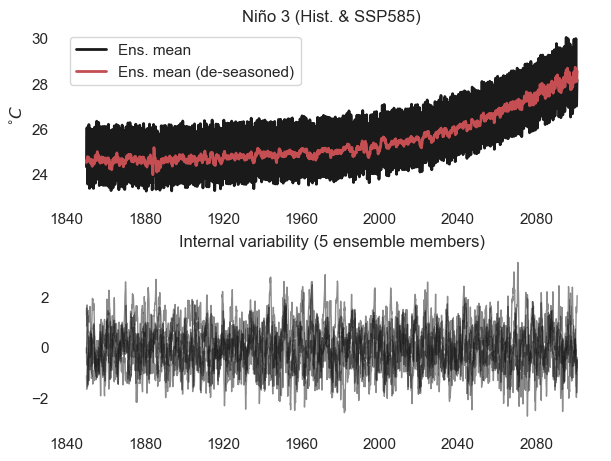

In [4]:
## load data into memory
Th_emean.load()

## function to deseason data
deseason = lambda x: x.groupby("time.month") - x.groupby("time.month").mean()

## remove seasonal cycle but add back time-mean
Th_emean_deseasoned = deseason(Th_emean) + Th_emean.mean("time")

## set up plot
fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), layout="constrained")

## plot data
axs[0].plot(Th_emean.time, Th_emean["T_3"], lw=2, c="k", label="Ens. mean")
axs[0].plot(
    Th_emean.time,
    Th_emean_deseasoned["T_3"],
    lw=2,
    c="r",
    label="Ens. mean (de-seasoned)",
)

## label
axs[0].legend()
axs[0].set_title("Niño 3 (Hist. & SSP585)")
axs[0].set_ylabel(r"$^{\circ}C$")

## plot 5 ensemble members
for i in range(1, 6):
    axs[1].plot(Th.time, Th["T_3"].sel(member=i), lw=1, c="k", alpha=0.5)

axs[1].set_title("Internal variability (5 ensemble members)")
plt.show()

## Data compression with EOFs (**to-do**)

Steps
1. Compute spatial patterns
2. Compress data
3. Check compression (compare recon of random ensemble to actual)
4. Remove ensemble mean (external forcing)

In [ ]:
## load single member
data = xr.concat(
    [load_member("ts", "historical", 1), load_member("ts", "ssp585", 1)], dim="time"
)
data.load()

## initialize EOF object
e = eof(data["sst"])